In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('/content/drive/MyDrive/MSBA Fall 2024/502 Analytics Programming/Amazon_Reviews.csv', engine='python')

# **Data Cleaning**

In [4]:
# Extract integer rating and review count

df['Rating (Int)'] = df['Rating'].str.extract('(\d)').fillna(0).astype(int)
df['Review Count (Int)'] = df['Review Count'].str.extract('(\d+)').fillna(0).astype(int)

In [5]:
# Clean review text

def clean_text(text):
  text = text.lower()
  text = ''.join([char for char in text if char not in string.punctuation])
  words = text.split()
  words = [word for word in words if word not in stop_words]
  return words

df['Review Text (Clean)'] = df['Review Text'].apply(lambda x: clean_text(str(x)))

In [6]:
# Create binary 'Positive' label
# 1 indicates a positive review (rating of 4 or higher), 0 indicates a negative review (rating of 3 or lower)

df['Positive'] = df['Rating (Int)'].apply(lambda x: 1 if x >= 4 else 0)

# **EDA**

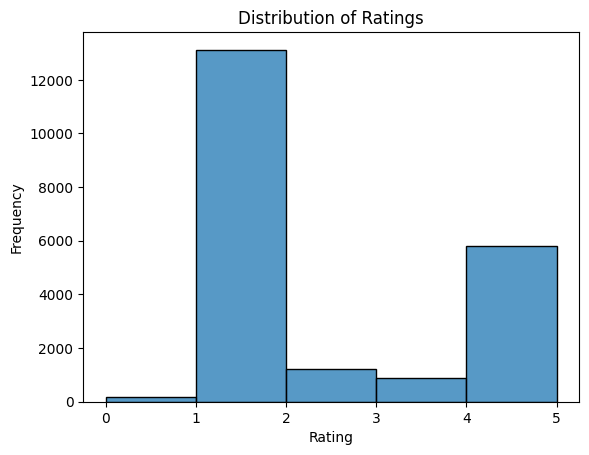

In [7]:
# Plot frequency of ratings

sns.histplot(data=df, x='Rating (Int)', bins=5)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

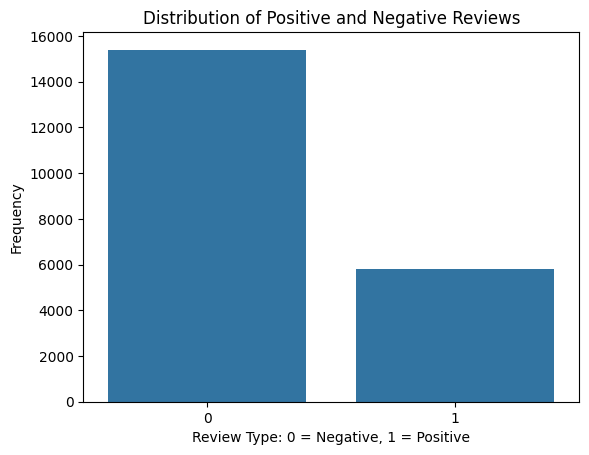

In [8]:
# Plot distribution of positive and negative reviews

sns.countplot(x='Positive', data=df)
plt.title('Distribution of Positive and Negative Reviews')
plt.xlabel('Review Type: 0 = Negative, 1 = Positive')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Define function that outputs n most common words by review type (positive or negative)

def top_review_words(review_type, n):
    """
    Args:
        review_type (str): String containing type of review to analyze ('positive' or 'negative').
        n (int): Number of most common words to return.

    Returns:
        A list of tuples containing the n most common words and their counts in the specified review type.
    """
    if review_type.lower() == 'positive':
        reviews = df[df['Positive'] == 1]['Review Text (Clean)']
    elif review_type.lower() == 'negative':
        reviews = df[df['Positive'] == 0]['Review Text (Clean)']
    else:
        return "Invalid input"

    words = ' '.join([' '.join(review) for review in reviews])
    word_counts = Counter(words.split())
    top_word_counts = word_counts.most_common(n)

    return top_word_counts

In [10]:
# Create lists of top 50 words in each review type

n = 50

top_positive_words = [word for word, count in top_review_words('positive', n)]
top_negative_words = [word for word, count in top_review_words('negative', n)]

print(f"Top {n} words in positive reviews:\n", top_positive_words)
print(f"Top {n} words in negative reviews:\n", top_negative_words)

Top 50 words in positive reviews:
 ['amazon', 'service', 'always', 'customer', 'great', 'good', 'delivery', 'time', 'prime', 'love', 'get', 'items', 'never', 'best', 'products', 'order', 'shipping', 'one', 'fast', 'company', 'prices', 'shopping', 'found', 'review', 'easy', 'use', 'day', 'everything', 'buy', 'like', 'online', 'years', 'find', 'experience', 'ive', 'would', 'problem', 'product', 'really', 'free', 'item', 'many', 'ordered', 'things', 'text', 'even', 'excellent', 'need', 'return', 'site']
Top 50 words in negative reviews:
 ['amazon', 'customer', 'service', 'get', 'delivery', 'order', 'time', 'account', 'item', 'prime', 'refund', 'would', 'one', 'never', 'money', 'even', 'items', 'back', 'day', 'delivered', 'told', 'days', 'company', 'dont', 'said', 'ordered', 'card', 'like', 'got', 'still', 'received', 'return', 'could', '2', 'email', 'package', 'product', 'call', 'phone', 'use', 'give', 'im', 'people', 'times', 'shipping', 'called', 'sent', 'review', 'want', 'another']


In [11]:
# Find words that appear in both lists

common_words = set(top_positive_words) & set(top_negative_words)

print(f"Common words in both positive and negative reviews:\n", common_words)

Common words in both positive and negative reviews:
 {'delivery', 'review', 'return', 'even', 'item', 'order', 'day', 'use', 'like', 'amazon', 'service', 'customer', 'product', 'would', 'shipping', 'company', 'get', 'prime', 'ordered', 'one', 'items', 'never', 'time'}


In [12]:
top_positive_words_unique = [word for word in top_positive_words if word not in common_words]

print(f"Top words unique to positive reviews:\n", top_positive_words_unique)

Top words unique to positive reviews:
 ['always', 'great', 'good', 'love', 'best', 'products', 'fast', 'prices', 'shopping', 'found', 'easy', 'everything', 'buy', 'online', 'years', 'find', 'experience', 'ive', 'problem', 'really', 'free', 'many', 'things', 'text', 'excellent', 'need', 'site']


Based on the top words that are unique to positive reviews, we will now select words to train the model.

The 10 words we have selected are:

1. great
2. good
3. love
4. best
5. fast
6. prices
7. found
8. easy
9. free
10. excellent

# **Model**

In [13]:
selected_words = ['great', 'good', 'love', 'best', 'fast', 'prices', 'found', 'easy', 'free', 'excellent']

In [14]:
# Define function that creates feature matrix given words

def words_in_reviews(words, reviews):
    """
    Args:
        words (list): List of words to search for in the reviews.
        reviews (Series): Series of cleaned review texts.

    Returns:
        A DataFrame with one column per word. Each cell contains 1 if the word is present, 0 otherwise.
    """
    indicator_matrix = pd.DataFrame({word: reviews.apply(lambda review: int(word in review)) for word in words})
    return indicator_matrix

In [15]:
# Create a 90/10 train-validation split on labeled data

X = words_in_reviews(selected_words, df['Review Text (Clean)'])
y = df['Positive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [16]:
# Train the Logistic Regression model and make predictions on training set

my_model = LogisticRegression(fit_intercept=True)
my_model.fit(X_train, y_train)

Y_fitted = my_model.predict(X_train)

In [17]:
import pandas as pd

def evaluate_model(model, X_train, y_train):
    """
    Evaluates a logistic regression model and returns metrics as a DataFrame.

    Args:
        model: The trained logistic regression model.
        X_train: Features used for training.
        y_train: True labels for the training data.

    Returns:
        A DataFrame with the training accuracy, precision, recall, and false positive rate.
    """
    y_train_hat = model.predict(X_train)
    accuracy = sum(y_train == y_train_hat) / len(y_train)

    TP = sum((y_train == 1) & (y_train == y_train_hat))
    TN = sum((y_train == 0) & (y_train == y_train_hat))
    FP = sum((y_train == 0) & (y_train != y_train_hat))
    FN = sum((y_train == 1) & (y_train != y_train_hat))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0

    metrics = {
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'False Positive Rate': [fpr],
        'True Positives': [TP],
        'True Negatives': [TN],
        'False Positives': [FP],
        'False Negatives': [FN]
    }

    return pd.DataFrame(metrics)

In [18]:
# Print the metrics of model

my_model_metrics = evaluate_model(my_model, X_train, y_train)

print("Logistic Predictor Metrics:\n")
print(my_model_metrics.to_string())

Logistic Predictor Metrics:

   Accuracy  Precision    Recall  False Positive Rate  True Positives  True Negatives  False Positives  False Negatives
0  0.776608   0.721622  0.305201             0.044644            1602           13225              618             3647


In [19]:
# The zero predictor always classifies the label 'Positive' as 0
# Calculate false positives, false negatives, accuracy, and recall when evaluated on y_train

zero_predictor_fp = 0
zero_predictor_fn = sum(y_train)
zero_predictor_acc = sum(y_train == 0)/len(y_train)
zero_predictor_recall = 0 / zero_predictor_fn

zero_predictor_metrics = pd.DataFrame({
    'Accuracy': [zero_predictor_acc],
    'Recall': [zero_predictor_recall],
    'False Positives': [zero_predictor_fp],
    'False Negatives': [zero_predictor_fn]
})

print("Zero Predictor Metrics:\n")
print(zero_predictor_metrics.to_string())

Zero Predictor Metrics:

   Accuracy  Recall  False Positives  False Negatives
0  0.725068     0.0                0             5249


# **Model Tuning**

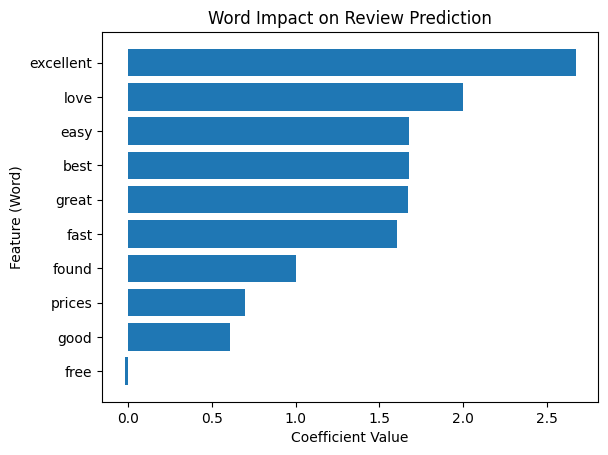

In [20]:
# Graph word impact on review prediction

coefficients = my_model.coef_[0]

sorted_indices = np.argsort(coefficients)
sorted_features = X_train.columns[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

plt.barh(sorted_features, sorted_coefficients)
plt.title('Word Impact on Review Prediction')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature (Word)')
plt.show()

In [21]:
# Select the top 5 words and regenerate model

selected_words_2 = ['excellent', 'love', 'easy', 'best', 'great']

X_2 = words_in_reviews(selected_words_2, df['Review Text (Clean)'])
y = df['Positive']

X_train_2, X_test_2, y_train, y_test = train_test_split(X_2, y, test_size=0.1, random_state=42)

my_model_2 = LogisticRegression(fit_intercept=True)
my_model_2.fit(X_train_2, y_train)

Y_fitted_2 = my_model_2.predict(X_train_2)

my_model_2_metrics = evaluate_model(my_model_2, X_train_2, y_train)

print("Tuned Logistic Predictor Metrics:\n")
print(my_model_2_metrics.to_string())

Tuned Logistic Predictor Metrics:

   Accuracy  Precision    Recall  False Positive Rate  True Positives  True Negatives  False Positives  False Negatives
0  0.785093   0.659788  0.450753             0.088131            2366           12623             1220             2883


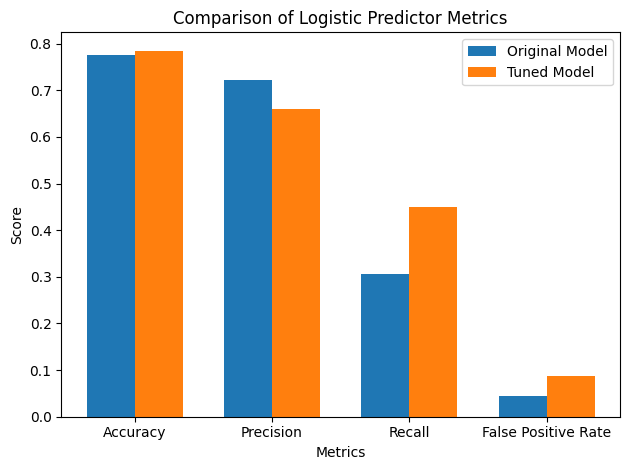

In [22]:
# Plot the comparison of accuracy, precision, recall, and false positive rate for both models

combined_metrics = pd.concat([my_model_metrics.T, my_model_2_metrics.T], axis=1)
combined_metrics.columns = ['Original Model', 'Tuned Model']
filtered_metrics = combined_metrics.loc[['Accuracy', 'Precision', 'Recall', 'False Positive Rate']]

bar_width = 0.35
index = np.arange(len(filtered_metrics.index))

fig, ax = plt.subplots()

bar1 = ax.bar(index, filtered_metrics['Original Model'], bar_width, label='Original Model')
bar2 = ax.bar(index + bar_width, filtered_metrics['Tuned Model'], bar_width, label='Tuned Model')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Logistic Predictor Metrics')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(filtered_metrics.index, rotation=0)

ax.legend()

plt.tight_layout()
plt.show()

The **tuned model** with fewer features shows slightly better overall accuracy and predicts a higher proportion of positive reviews (higher recall). However, it also generates more false positive predictions, meaning that some negative reviews are incorrectly classified as positive.

The **original model** with more features has better precision, meaning its positive predictions are more likely to be correct. It also has a lower false positive rate, reducing the chance of misclassifying negative reviews. However, the original model misses more actual positive reviews than the tuned model (lower recall).

We believe that the **original model** is more applicable to this Amazon review dataset because:
* The original model is less likely to misclassify negative reviews as positive, which maintains accuracy and trust in reporting. This is important when using reviews for marketing or advertising purposes.
* With a lower false positive rate, businesses are less likely to overlook critical feedback or customer issues that could have been mistakenly classified as positive.

# **Data Visualization**


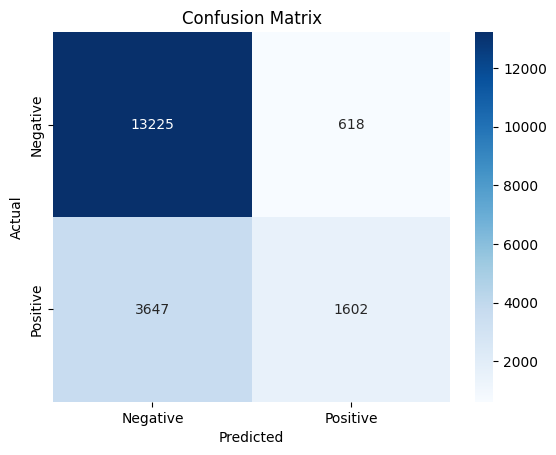

In [23]:
# Create a heatmap to visualize confusion matrix of original model

y_train_hat = my_model.predict(X_train)

cm = confusion_matrix(y_train, y_train_hat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

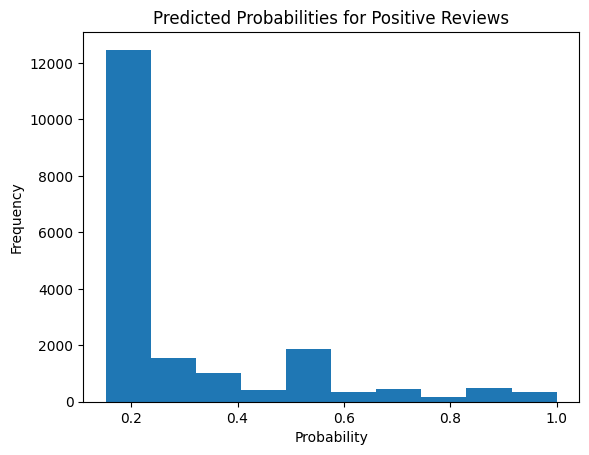

In [24]:
# Plot histogram of the predicted probabilities of a positive review

y_train_prob = my_model.predict_proba(X_train)[:, 1]

plt.hist(y_train_prob, bins=10)
plt.title('Predicted Probabilities for Positive Reviews')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

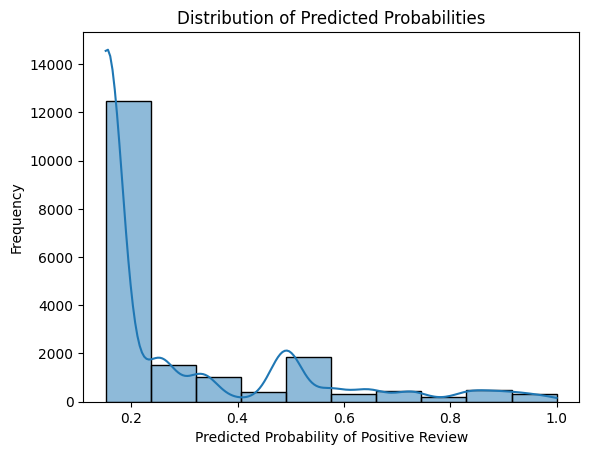

In [25]:
# Plot the distribution of predicted probabilities

sns.histplot(y_train_prob, bins=10, kde=True)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability of Positive Review')
plt.ylabel('Frequency')
plt.show()

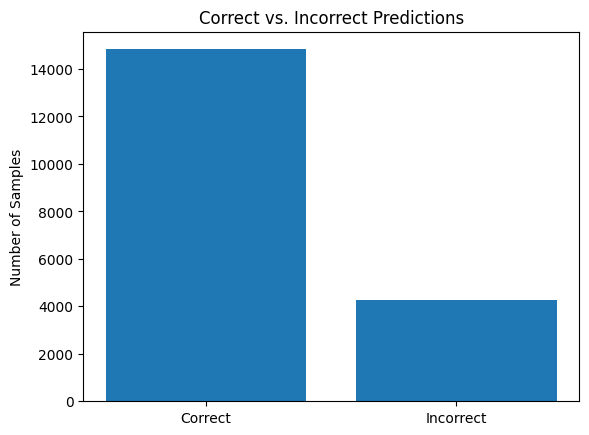

In [26]:
# Plot incorrect vs. correct predictions

correct_predictions = (y_train == y_train_hat).sum()
incorrect_predictions = (y_train != y_train_hat).sum()

plt.bar(['Correct', 'Incorrect'], [correct_predictions, incorrect_predictions])
plt.title('Correct vs. Incorrect Predictions')
plt.ylabel('Number of Samples')
plt.show()